In [1]:
import pandas as pd
import numpy as np

In [2]:
import matplotlib.pyplot as plt
import seaborn as sb
sb.set(style="whitegrid")
%matplotlib inline

In [3]:
from matplotlib import rcParams
rcParams['figure.figsize'] = 10, 7

In [4]:
from imblearn.under_sampling import TomekLinks

from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

## 1. Baja el archivo caudal_extra.csv

In [5]:
df = pd.read_csv("caudal_extra.csv", index_col=0)
df.head()

C:\Users\Satellite\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,codigo_estacion,institucion,fuente,nombre,altura,latitud,longitud,codigo_cuenca,nombre_sub_cuenca,cantidad_observaciones,fecha,caudal,gauge_id,gauge_name,precip_promedio,temp_max_promedio
0,4540001,DGA,dga_web,Rio Grande En Paloma 1,310,-30.6833,-71.050003,45,Rio Grande Bajo (Entre E Paloma Y Rio Hurtado),11575,1960-01-06 00:00:00+00:00,0.812,4540001,Rio Grande En Paloma 1,0.0,NaN
1,4540001,DGA,dga_web,Rio Grande En Paloma 1,310,-30.6833,-71.050003,45,Rio Grande Bajo (Entre E Paloma Y Rio Hurtado),11575,1960-03-27 00:00:00+00:00,0.236,4540001,Rio Grande En Paloma 1,0.0,NaN
2,4540001,DGA,dga_web,Rio Grande En Paloma 1,310,-30.6833,-71.050003,45,Rio Grande Bajo (Entre E Paloma Y Rio Hurtado),11575,1960-05-07 00:00:00+00:00,0.730,4540001,Rio Grande En Paloma 1,0.0,NaN
3,4540001,DGA,dga_web,Rio Grande En Paloma 1,310,-30.6833,-71.050003,45,Rio Grande Bajo (Entre E Paloma Y Rio Hurtado),11575,1960-06-30 00:00:00+00:00,3.590,4540001,Rio Grande En Paloma 1,0.0,NaN
4,4540001,DGA,dga_web,Rio Grande En Paloma 1,310,-30.6833,-71.050003,45,Rio Grande Bajo (Entre E Paloma Y Rio Hurtado),11575,1960-07-22 00:00:00+00:00,1.370,4540001,Rio Grande En Paloma 1,0.0,NaN


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1411180 entries, 0 to 1411179
Data columns (total 16 columns):
codigo_estacion           1411180 non-null int64
institucion               1411180 non-null object
fuente                    1411180 non-null object
nombre                    1411180 non-null object
altura                    1411180 non-null int64
latitud                   1411180 non-null float64
longitud                  1411180 non-null float64
codigo_cuenca             1411180 non-null int64
nombre_sub_cuenca         1411180 non-null object
cantidad_observaciones    1411180 non-null int64
fecha                     1411180 non-null object
caudal                    1411180 non-null float64
gauge_id                  1411180 non-null int64
gauge_name                1411180 non-null object
precip_promedio           1383413 non-null float64
temp_max_promedio         1259617 non-null float64
dtypes: float64(5), int64(5), object(6)
memory usage: 183.0+ MB


In [7]:
df.isnull().sum()

codigo_estacion                0
institucion                    0
fuente                         0
nombre                         0
altura                         0
latitud                        0
longitud                       0
codigo_cuenca                  0
nombre_sub_cuenca              0
cantidad_observaciones         0
fecha                          0
caudal                         0
gauge_id                       0
gauge_name                     0
precip_promedio            27767
temp_max_promedio         151563
dtype: int64

In [8]:
df.nunique()

codigo_estacion             133
institucion                   1
fuente                        1
nombre                      133
altura                      101
latitud                     133
longitud                    130
codigo_cuenca                29
nombre_sub_cuenca            78
cantidad_observaciones      132
fecha                     21252
caudal                    29154
gauge_id                    133
gauge_name                  133
precip_promedio           33004
temp_max_promedio         35729
dtype: int64

### Chequear variable "gauge_id"

In [9]:
df[['codigo_estacion', 'gauge_id']].sample(5)

,codigo_estacion,gauge_id
1050579,4711001,4711001
769219,2104002,2104002
1293902,4323001,4323001
83330,1021001,1021001
640081,5710001,5710001


In [10]:
# Comprobar que para ningún registro 'codigo_estacion' sea distinto a 'gauge_id':
len(df[df['codigo_estacion']!=df['gauge_id']])

0

### Chequear variable "fecha"

In [11]:
df['fecha'] = pd.to_datetime(df['fecha'])
df['hora'] = df['fecha'].dt.time
df['hora'].describe()

The history saving thread hit an unexpected error (OperationalError('disk I/O error')).History will not be written to the database.


count      1411180
unique           1
top       00:00:00
freq       1411180
Name: hora, dtype: object

### Aplicar transformaciones pertinentes al dataset

In [12]:
# Convertir variable "fecha" a tipo "datetime":
df['fecha'] = df['fecha'].dt.date
df['fecha'] = pd.to_datetime(df['fecha'])

# Eliminar las columnas que no son necesarias:
df.drop(
    ['institucion', 
     'fuente',
     'nombre',
     'nombre_sub_cuenca',
     'cantidad_observaciones',
     'hora',
     'gauge_id',
     'gauge_name'], axis=1, inplace=True)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1411180 entries, 0 to 1411179
Data columns (total 9 columns):
codigo_estacion      1411180 non-null int64
altura               1411180 non-null int64
latitud              1411180 non-null float64
longitud             1411180 non-null float64
codigo_cuenca        1411180 non-null int64
fecha                1411180 non-null datetime64[ns]
caudal               1411180 non-null float64
precip_promedio      1383413 non-null float64
temp_max_promedio    1259617 non-null float64
dtypes: datetime64[ns](1), float64(5), int64(3)
memory usage: 107.7 MB


In [14]:
df.head()

,codigo_estacion,altura,latitud,longitud,codigo_cuenca,fecha,caudal,precip_promedio,temp_max_promedio
0,4540001,310,-30.6833,-71.050003,45,1960-01-06,0.812,0.0,NaN
1,4540001,310,-30.6833,-71.050003,45,1960-03-27,0.236,0.0,NaN
2,4540001,310,-30.6833,-71.050003,45,1960-05-07,0.730,0.0,NaN
3,4540001,310,-30.6833,-71.050003,45,1960-06-30,3.590,0.0,NaN
4,4540001,310,-30.6833,-71.050003,45,1960-07-22,1.370,0.0,NaN


## 2. Analiza el dataset caudal_extra.csv. ¿Qué puedes decir de los datos, distribuciones, missing, u otros? ¿Hay algo que te llame la atención? ¿Por qué hay tantos valores missing? Pensar en la manera en que se elaboró el dataset, descrito más arriba. (Entregable: texto/imágenes)

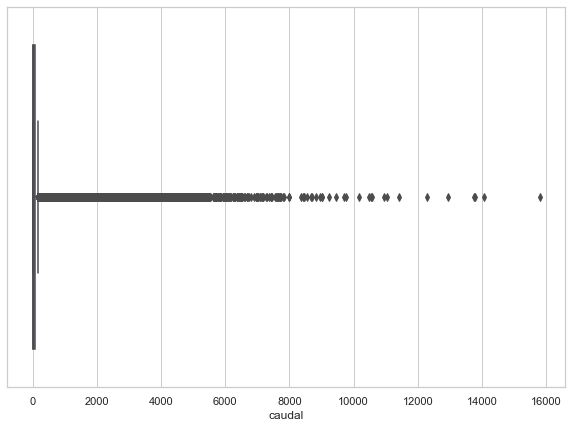

In [15]:
sb.boxplot(df['caudal'])

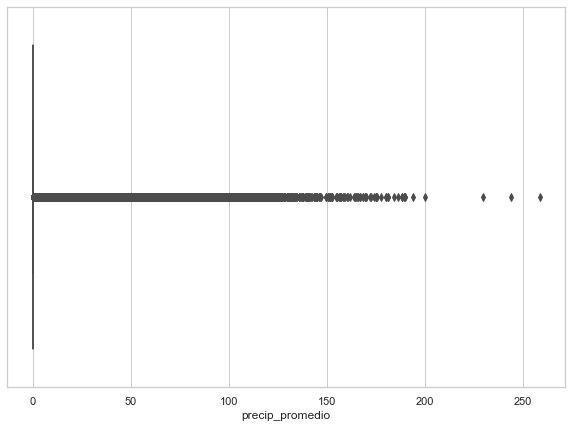

In [16]:
sb.boxplot(df['precip_promedio'])

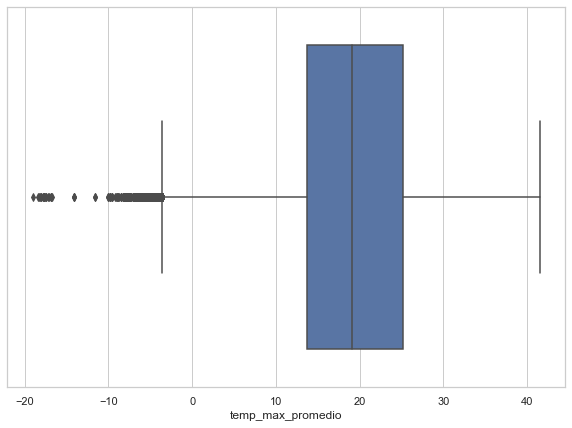

In [17]:
sb.boxplot(df['temp_max_promedio'])

Como se puede evidenciar en los boxplots graficados arriba, las variables "caudal" y "precip_promedio" están muy lejos de tener distribuciones normales, con una acentuada asimetría positiva concentrándose la mayoría de sus valores cerca de cero. También llama la atención el contraste con respecto a las enormes magnitudes de los valores atípicos en ambos casos. En cambio, la variable "temp_max_promedio" sí posee una distribución más cercana a la distribución normal, destacando además que los valores atípicos se hallan en el rango de temperaturas mínimas.

Ahora, revisemos las correlaciones entre las variables aplicando tanto el método de Pearson como el método de Spearman para calcular las mismas.

In [18]:
df.corr()

,codigo_estacion,altura,latitud,longitud,codigo_cuenca,caudal,precip_promedio,temp_max_promedio
codigo_estacion,1.000000,-0.592091,-0.979942,-0.859722,0.991038,0.379055,0.163647,-0.285342
altura,-0.592091,1.000000,0.635112,0.768335,-0.573129,-0.198266,-0.094212,-0.111890
latitud,-0.979942,0.635112,1.000000,0.846466,-0.969998,-0.348209,-0.136393,0.237541
longitud,-0.859722,0.768335,0.846466,1.000000,-0.839962,-0.390946,-0.161121,0.103177
codigo_cuenca,0.991038,-0.573129,-0.969998,-0.839962,1.000000,0.380675,0.162695,-0.297615
caudal,0.379055,-0.198266,-0.348209,-0.390946,0.380675,1.000000,0.191504,-0.233441
precip_promedio,0.163647,-0.094212,-0.136393,-0.161121,0.162695,0.191504,1.000000,-0.259801
temp_max_promedio,-0.285342,-0.111890,0.237541,0.103177,-0.297615,-0.233441,-0.259801,1.000000


Las correlaciones más altas se dan entre las variables "codigo_estacion", "altura", "latitud", "longitud" y "codigo_cuenca". Esto en principio no es muy útil, pero claramente se puede intuir que la asignación de los códigos tiene una connotación geográfica, lo que puede ayudar a reducir la cantidad de variables independientes.

In [19]:
df.corr(method='spearman')

,codigo_estacion,altura,latitud,longitud,codigo_cuenca,caudal,precip_promedio,temp_max_promedio
codigo_estacion,1.000000,-0.577544,-0.994038,-0.904755,0.988028,0.737018,0.375476,-0.274290
altura,-0.577544,1.000000,0.539298,0.747021,-0.543543,-0.400426,-0.246100,0.052741
latitud,-0.994038,0.539298,1.000000,0.886270,-0.991459,-0.732183,-0.371260,0.282811
longitud,-0.904755,0.747021,0.886270,1.000000,-0.881848,-0.679764,-0.365379,0.185163
codigo_cuenca,0.988028,-0.543543,-0.991459,-0.881848,1.000000,0.738464,0.370630,-0.280487
caudal,0.737018,-0.400426,-0.732183,-0.679764,0.738464,1.000000,0.389995,-0.307073
precip_promedio,0.375476,-0.246100,-0.371260,-0.365379,0.370630,0.389995,1.000000,-0.452972
temp_max_promedio,-0.274290,0.052741,0.282811,0.185163,-0.280487,-0.307073,-0.452972,1.000000


En el caso del método Spearman, nos concentramos más bien en las correlaciones con respecto a la variable "caudal", viendo que las variables de tipo geográfica y los códigos son las que presentan correlaciones altas. 

Ahora veamos los gráficos de dispersión (scatterplots) de todas las variables con respecto a la variable "caudal".

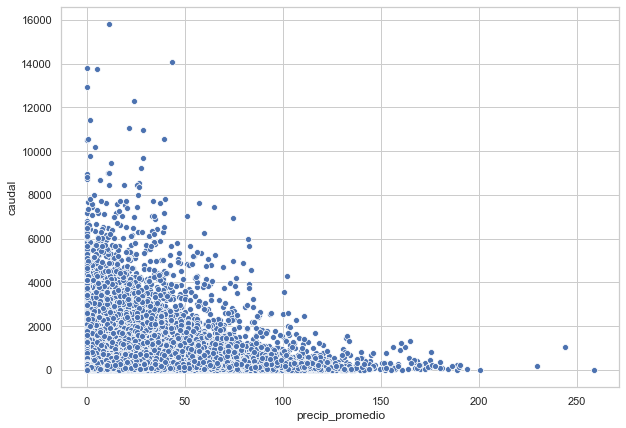

In [20]:
sb.scatterplot(x='precip_promedio', y='caudal', data=df)

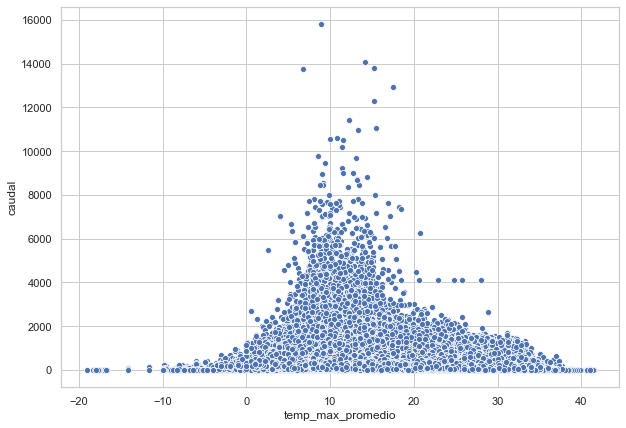

In [21]:
sb.scatterplot(x='temp_max_promedio', y='caudal', data=df)

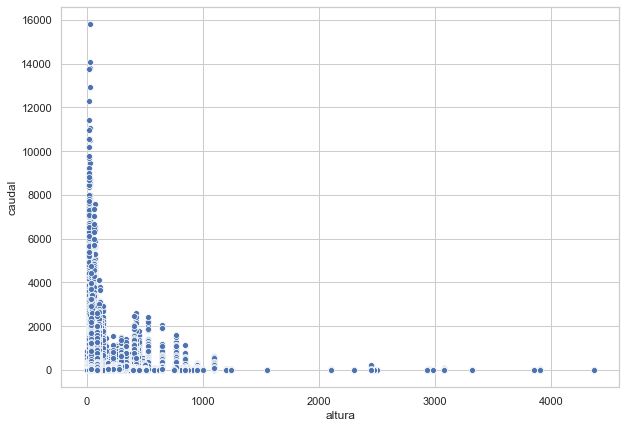

In [22]:
sb.scatterplot(x='altura', y='caudal', data=df)

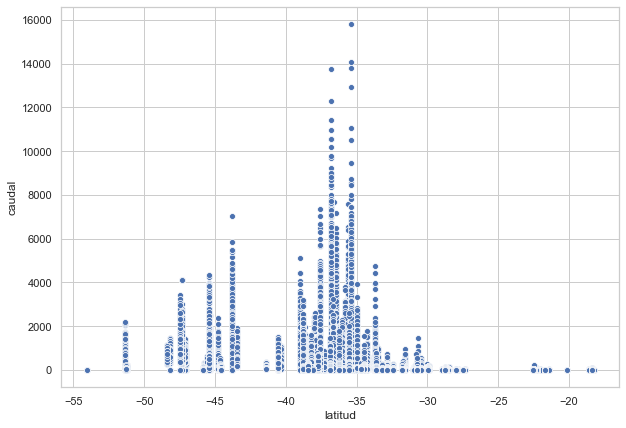

In [23]:
sb.scatterplot(x='latitud', y='caudal', data=df)

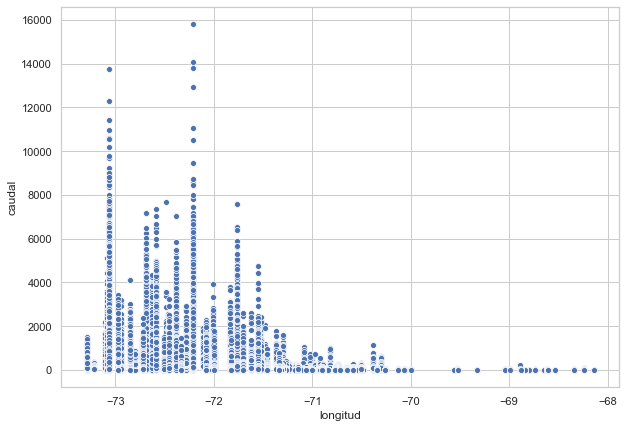

In [24]:
sb.scatterplot(x='longitud', y='caudal', data=df)

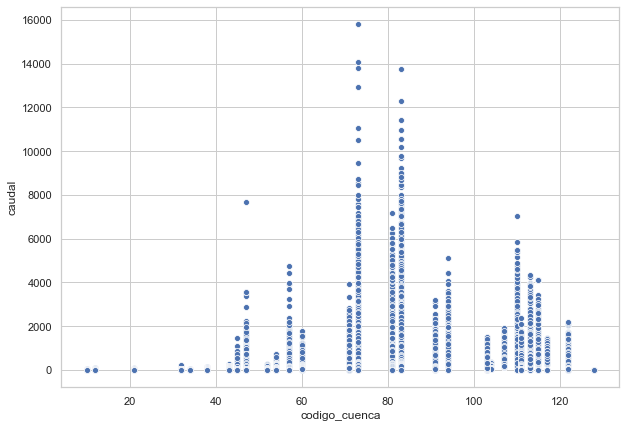

In [25]:
sb.scatterplot(x='codigo_cuenca', y='caudal', data=df)

En ninguno de los gráficos de dispersión se puede apreciar una clara correlación lineal con respecto a la variable "caudal". No obstante, se puede observar que los valores más altos de caudal tienden a concentrarse en un determinado rango de cada variable independiente.

Ahora grafiquemos las variables "temp_max_promedio" y "precip_promedio".

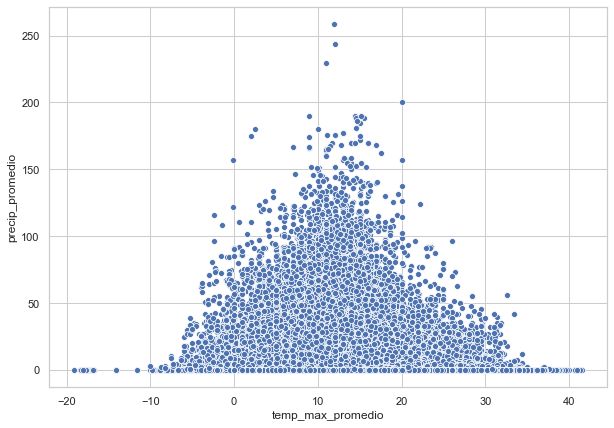

In [26]:
sb.scatterplot(x='temp_max_promedio', y='precip_promedio', data=df)

En este caso sucede un fenómeno similar: no se aprecia una clara correlación lineal, y además los valores más altos de precipitación se concentran en un rango de la temperatura.

Para continuar con el análisis, eliminamos aquellos registros que posean valores nulos, bien sean de precipitación o de temperatura. 

In [27]:
df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1411180 entries, 0 to 1411179
Data columns (total 9 columns):
codigo_estacion      1411180 non-null int64
altura               1411180 non-null int64
latitud              1411180 non-null float64
longitud             1411180 non-null float64
codigo_cuenca        1411180 non-null int64
fecha                1411180 non-null datetime64[ns]
caudal               1411180 non-null float64
precip_promedio      1383413 non-null float64
temp_max_promedio    1259617 non-null float64
dtypes: datetime64[ns](1), float64(5), int64(3)
memory usage: 107.7 MB


In [28]:
df.describe()

,codigo_estacion,altura,latitud,longitud,codigo_cuenca,caudal,precip_promedio,temp_max_promedio
count,1.411180e+06,1.411180e+06,1.411180e+06,1.411180e+06,1.411180e+06,1.411180e+06,1.383413e+06,1.259617e+06
mean,6.279953e+06,5.855691e+02,-3.367748e+01,-7.121826e+01,6.255881e+01,9.552229e+01,1.921009e+00,1.921110e+01
std,2.891695e+06,8.652682e+02,6.940820e+00,1.174363e+00,2.839921e+01,2.526337e+02,7.361936e+00,7.307081e+00
min,1.020003e+06,0.000000e+00,-5.404110e+01,-7.328330e+01,1.000000e+01,0.000000e+00,0.000000e+00,-1.905000e+01
25%,4.320001e+06,4.500000e+01,-3.721190e+01,-7.206810e+01,4.300000e+01,1.250000e+00,0.000000e+00,1.370000e+01
50%,5.734001e+06,3.950000e+02,-3.359390e+01,-7.125470e+01,5.700000e+01,8.950000e+00,0.000000e+00,1.908429e+01
75%,8.308000e+06,7.500000e+02,-2.994580e+01,-7.053280e+01,8.300000e+01,6.970000e+01,0.000000e+00,2.520000e+01
max,1.287600e+07,4.370000e+03,-1.823250e+01,-6.814390e+01,1.280000e+02,1.580500e+04,2.586000e+02,4.150000e+01


## 3. Plots de precipitación, temperatura y caudal

### a. Escribir una función que tome como input una estación y haga plot de los datos para una columna.

In [29]:
def time_plot_una_estacion(codigo_estacion, columna, fecha_min, fecha_max):
    data = df[df['codigo_estacion']==codigo_estacion]
    data.plot.line(x='fecha', y=columna)
    plt.axis(xmin=fecha_min, xmax=fecha_max)

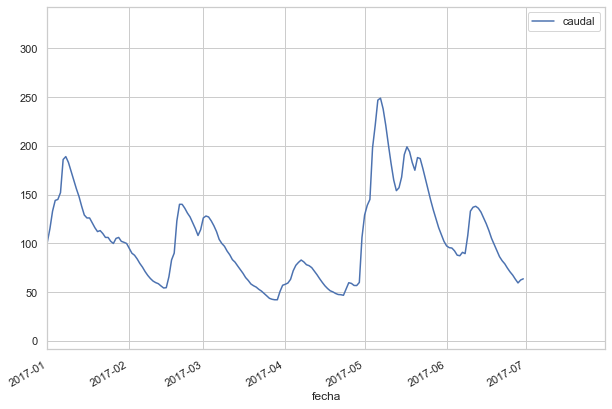

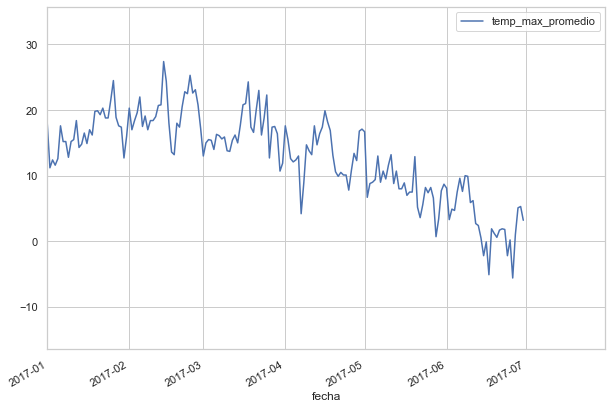

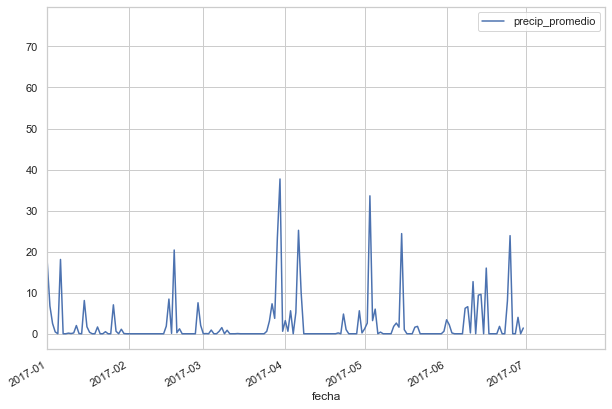

In [30]:
time_plot_una_estacion(11335002, 'caudal', '2017-01-01', '2017-07-31')
time_plot_una_estacion(11335002, 'temp_max_promedio', '2017-01-01', '2017-07-31')
time_plot_una_estacion(11335002, 'precip_promedio', '2017-01-01', '2017-07-31')

### b. Ahora escribir una función que haga plots de varias columnas, para poder visualizar caudal, precipitación y temperatura al mismo tiempo.

In [31]:
def time_plot_estaciones_varias_columnas(codigo_estacion, columnas, fecha_min, fecha_max):
    data = df[df['codigo_estacion']==codigo_estacion]
    data = data.set_index('fecha')
    data = data[columnas]
    data.plot.line()
    plt.axis(xmin=fecha_min, xmax=fecha_max)

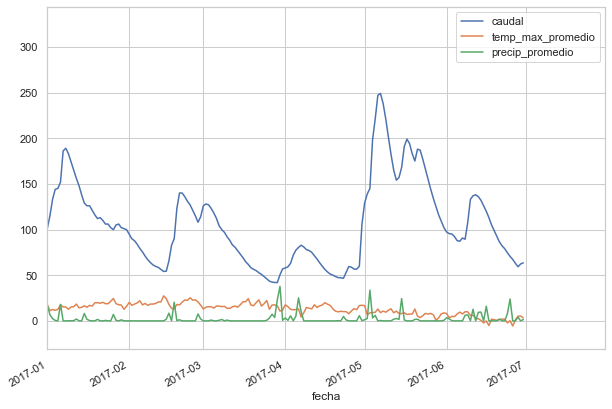

In [32]:
time_plot_estaciones_varias_columnas(11335002, 
                                     ['caudal', 'temp_max_promedio', 'precip_promedio'], 
                                     '2017-01-01', 
                                     '2017-07-31')

## 4. Crea tres variables llamadas caudal_extremo, temp_extremo, precip_extremo

In [33]:
df['mes'] = df['fecha'].dt.month
df.groupby(by='mes')['temp_max_promedio'].mean()

mes
1     24.913804
2     24.862889
3     23.188604
4     19.691163
5     16.035531
6     13.459384
7     13.042997
8     14.594274
9     16.705605
10    19.138382
11    21.521446
12    23.599283
Name: temp_max_promedio, dtype: float64

In [34]:
df['estacion_año'] = df['fecha'].dt.month

estaciones = {1:'verano', 
              2:'verano', 
              3:'otoño', 
              4:'otoño', 
              5:'otoño', 
              6:'invierno', 
              7:'invierno', 
              8:'invierno', 
              9:'primavera', 
              10:'primavera', 
              11:'primavera', 
              12:'verano'}

df['estacion_año'] = df['estacion_año'].map(estaciones)

In [35]:
df.sample(3)

,codigo_estacion,altura,latitud,longitud,codigo_cuenca,fecha,caudal,precip_promedio,temp_max_promedio,mes,estacion_año
274145,4308001,890,-29.945801,-70.532799,43,2000-03-04,5.550,0.0,22.000000,3,otoño
797328,2105002,2980,-22.289400,-68.344704,21,2002-04-07,0.439,0.0,16.959999,4,otoño
316440,4726001,0,-31.664700,-71.254700,47,2004-01-07,0.078,0.0,28.000000,1,verano


In [36]:
caudal_p95 = df.groupby(by=['codigo_estacion', 'estacion_año'])['caudal'].quantile(0.95)
caudal_p95 = caudal_p95.rename('caudal_p95')
caudal_p95 = caudal_p95.reset_index()
caudal_p95.head()

,codigo_estacion,estacion_año,caudal_p95
0,1020003,invierno,0.2040
1,1020003,otoño,0.8112
2,1020003,primavera,0.1113
3,1020003,verano,1.2400
4,1021001,invierno,2.6400


In [37]:
temp_max_p95 = df.groupby(by=['codigo_estacion', 'estacion_año'])['temp_max_promedio'].quantile(0.95)
temp_max_p95 = temp_max_p95.rename('temp_max_p95')
temp_max_p95 = temp_max_p95.reset_index()
temp_max_p95.head()

,codigo_estacion,estacion_año,temp_max_p95
0,1020003,invierno,13.050
1,1020003,otoño,15.100
2,1020003,primavera,16.100
3,1020003,verano,16.196
4,1021001,invierno,13.000


In [38]:
precip_p95 = df.groupby(by=['codigo_estacion', 'estacion_año'])['precip_promedio'].quantile(0.95)
precip_p95 = precip_p95.rename('precip_p95')
precip_p95 = precip_p95.reset_index()
precip_p95.head()

,codigo_estacion,estacion_año,precip_p95
0,1020003,invierno,0.00000
1,1020003,otoño,5.25000
2,1020003,primavera,0.81000
3,1020003,verano,10.71025
4,1021001,invierno,0.00000


In [39]:
df_p95 = pd.merge(caudal_p95, temp_max_p95, on=['codigo_estacion', 'estacion_año'])
df_p95 = pd.merge(df_p95, precip_p95, on=['codigo_estacion', 'estacion_año'])
df_p95.head()

,codigo_estacion,estacion_año,caudal_p95,temp_max_p95,precip_p95
0,1020003,invierno,0.2040,13.050,0.00000
1,1020003,otoño,0.8112,15.100,5.25000
2,1020003,primavera,0.1113,16.100,0.81000
3,1020003,verano,1.2400,16.196,10.71025
4,1021001,invierno,2.6400,13.000,0.00000


In [40]:
df = pd.merge(df, df_p95, on=['codigo_estacion', 'estacion_año'])

df['caudal_extremo'] = (df['caudal'] > df['caudal_p95'])
df['temp_extremo'] = (df['temp_max_promedio'] > df['temp_max_p95'])
df['precip_extremo'] = (df['precip_promedio'] > df['precip_p95'])

df['caudal_extremo'] = df['caudal_extremo'].map({True:1, False:0})
df['temp_extremo'] = df['temp_extremo'].map({True:1, False:0})
df['precip_extremo'] = df['precip_extremo'].map({True:1, False:0})

df.sample(5)

,codigo_estacion,altura,latitud,longitud,codigo_cuenca,fecha,caudal,precip_promedio,temp_max_promedio,mes,estacion_año,caudal_p95,temp_max_p95,precip_p95,caudal_extremo,temp_extremo,precip_extremo
1251158,7332001,140,-36.233299,-72.000000,73,1990-11-14,2.37,0.000000,20.000000,11,primavera,117.000,27.200001,19.500000,0,0,0
65685,7379002,64,-35.452499,-71.733299,73,2004-10-24,68.50,0.022222,21.950001,10,primavera,167.350,28.922500,11.881111,0,0,0
558172,5704002,1092,-33.734699,-70.300797,57,1970-06-16,33.90,3.766667,17.000000,6,invierno,66.195,16.100000,28.000000,0,1,0
442927,7123001,20,-34.984402,-72.010002,71,2017-12-03,101.90,0.000000,27.459999,12,verano,204.000,33.043333,0.027273,0,0,0
312496,4726001,0,-31.664700,-71.254700,47,1992-09-26,5.20,0.000000,24.200001,9,primavera,13.600,29.200001,0.000000,0,0,0


### ¿Les parece razonable esta medida para capturar algo “extremo”? ¿Usarían otra? ¿Cuál?

In [41]:
df_p95.mean()

codigo_estacion    6.619852e+06
caudal_p95         2.447716e+02
temp_max_p95       2.499468e+01
precip_p95         1.063312e+01
dtype: float64

En principio sí parece bastante razonable para las variables de caudal y precipitación, ya que esta medida logra capturar únicamente valores atípicos según lo mostrado en los boxplots de la sección 2.

## 5. Analicen la variable caudal_extremo. Los comportamientos en diferentes cuencas son muy diferentes?

In [42]:
round(df['caudal_extremo'].mean(), 6)

0.049861

In [43]:
promedio_caudal_extremo_cuenca = df.groupby(by='codigo_cuenca')['caudal_extremo'].mean().rename('promedio_caudal_extremo')
promedio_caudal_extremo_cuenca.reset_index()

,codigo_cuenca,promedio_caudal_extremo
0,10,0.049602
1,12,0.050000
2,21,0.049401
3,32,0.050064
4,34,0.049937
5,38,0.049807
6,43,0.049825
7,45,0.049930
8,47,0.049848
9,52,0.049613


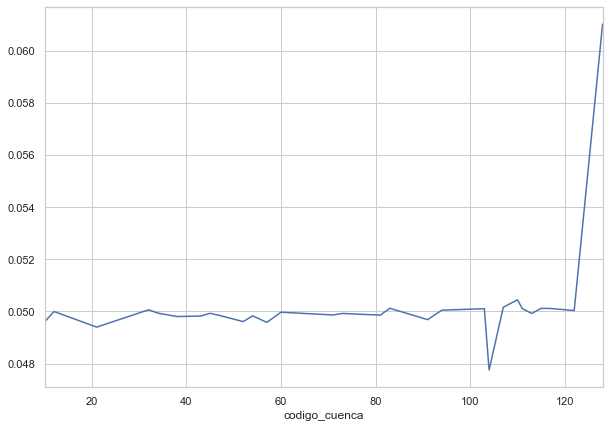

In [44]:
promedio_caudal_extremo_cuenca.plot()

A excepción de dos cuencas, el promedio de caudales extremos es muy similar entre todas las cuencas.

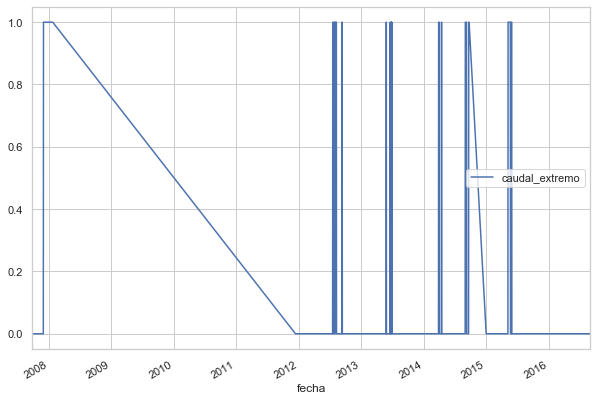

In [45]:
df[df['codigo_cuenca']==128].plot.line(x='fecha', y='caudal_extremo')

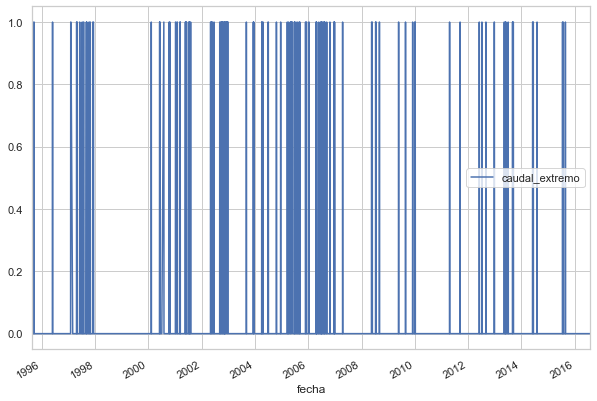

In [46]:
df[df['codigo_cuenca']==104].plot.line(x='fecha', y='caudal_extremo')

In [47]:
df['fecha'].describe()

count                 1411180
unique                  21252
top       2004-09-15 00:00:00
freq                      106
first     1960-01-02 00:00:00
last      2018-03-09 00:00:00
Name: fecha, dtype: object

Podemos pensar que la variación en los valores promedio de caudal extremo de las dos cuencas graficadas arriba se debe a que el rango de tiempo para el cual se ha recolectado mediciones es bastante limitado en ambos casos.

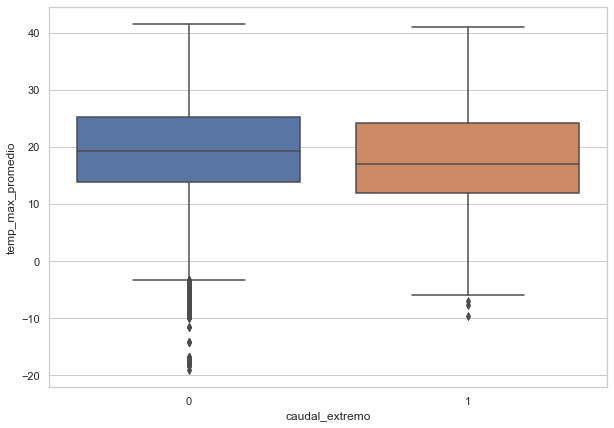

In [48]:
sb.boxplot(x='caudal_extremo' , y='temp_max_promedio', data=df)

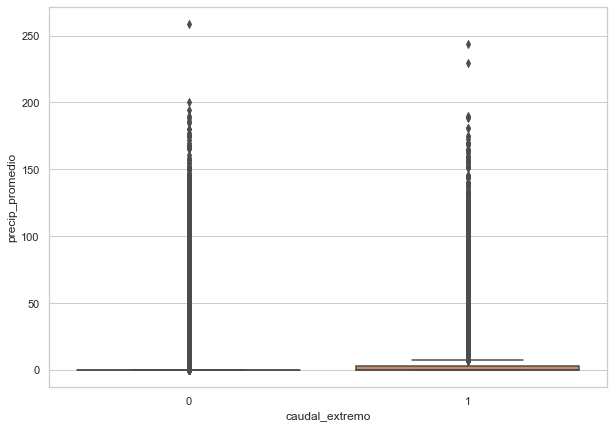

In [49]:
sb.boxplot(x='caudal_extremo' , y='precip_promedio', data=df)

En el par de boxplots graficados arriba tampoco se puede apreciar una clara correlación entre caudal extremo y las mediciones de precipitación y temperatura.

## 6. Hagan un plot del porcentaje de eventos extremos a través del tiempo (caudal_extremo, temp_extremo, precip_extremo). Se han vuelto más o menos comunes?

In [50]:
df['año'] = df['fecha'].dt.year
df['año'].head()

0    1960
1    1960
2    1961
3    1961
4    1963
Name: año, dtype: int64

In [51]:
pctaje_caudal_extremo = df.groupby(by=['codigo_estacion', 'año'])['caudal_extremo'].mean().rename('pctaje_caudal_extremo')
pctaje_caudal_extremo = pctaje_caudal_extremo.reset_index()
pctaje_caudal_extremo['pctaje_caudal_extremo'] = round((pctaje_caudal_extremo['pctaje_caudal_extremo']*100), 2)
pctaje_caudal_extremo.head()

,codigo_estacion,año,pctaje_caudal_extremo
0,1020003,1963,5.45
1,1020003,1964,0.00
2,1020003,1965,2.42
3,1020003,1984,0.00
4,1020003,1985,5.07


In [52]:
pctaje_temp_extremo = df.groupby(by=['codigo_estacion', 'año'])['temp_extremo'].mean().rename('pctaje_temp_extremo')
pctaje_temp_extremo = pctaje_temp_extremo.reset_index()
pctaje_temp_extremo['pctaje_temp_extremo'] = round((pctaje_temp_extremo['pctaje_temp_extremo']*100), 2)
pctaje_temp_extremo.head()

,codigo_estacion,año,pctaje_temp_extremo
0,1020003,1963,0.00
1,1020003,1964,0.00
2,1020003,1965,0.00
3,1020003,1984,0.00
4,1020003,1985,4.23


In [53]:
pctaje_precip_extremo = df.groupby(by=['codigo_estacion', 'año'])['precip_extremo'].mean().rename('pctaje_precip_extremo')
pctaje_precip_extremo = pctaje_precip_extremo.reset_index()
pctaje_precip_extremo['pctaje_precip_extremo'] = round((pctaje_precip_extremo['pctaje_precip_extremo']*100), 2)
pctaje_precip_extremo.head()

,codigo_estacion,año,pctaje_precip_extremo
0,1020003,1963,4.00
1,1020003,1964,5.75
2,1020003,1965,3.03
3,1020003,1984,0.00
4,1020003,1985,10.70


In [54]:
df_pctaje_valores_extremos = pd.merge(pctaje_caudal_extremo, pctaje_temp_extremo, on=['codigo_estacion', 'año'])
df_pctaje_valores_extremos = pd.merge(df_pctaje_valores_extremos, pctaje_precip_extremo, on=['codigo_estacion', 'año'])
df_pctaje_valores_extremos.head()

,codigo_estacion,año,pctaje_caudal_extremo,pctaje_temp_extremo,pctaje_precip_extremo
0,1020003,1963,5.45,0.00,4.00
1,1020003,1964,0.00,0.00,5.75
2,1020003,1965,2.42,0.00,3.03
3,1020003,1984,0.00,0.00,0.00
4,1020003,1985,5.07,4.23,10.70


In [55]:
conteo = df.groupby(by=['codigo_estacion', 'año'])['caudal'].count().reset_index()
conteo = conteo.rename(columns={'caudal': 'observaciones_anuales'})
conteo.head()

,codigo_estacion,año,observaciones_anuales
0,1020003,1963,275
1,1020003,1964,348
2,1020003,1965,165
3,1020003,1984,32
4,1020003,1985,355


In [56]:
df_pctaje_valores_extremos = pd.merge(df_pctaje_valores_extremos, conteo, on=['codigo_estacion', 'año'])
df_pctaje_valores_extremos = df_pctaje_valores_extremos[df_pctaje_valores_extremos['observaciones_anuales'] > 300]
df_pctaje_valores_extremos.head()

,codigo_estacion,año,pctaje_caudal_extremo,pctaje_temp_extremo,pctaje_precip_extremo,observaciones_anuales
1,1020003,1964,0.00,0.00,5.75,348
4,1020003,1985,5.07,4.23,10.70,355
5,1020003,1986,7.42,2.47,6.87,364
6,1020003,1987,5.75,15.62,6.58,365
7,1020003,1988,1.37,9.29,2.73,366


In [57]:
def time_plot_pctaje_valores_extremos_estacion(codigo_estacion):
    data = df_pctaje_valores_extremos[df_pctaje_valores_extremos['codigo_estacion']==codigo_estacion]
    data = data.set_index('año')
    data = data[['pctaje_caudal_extremo', 'pctaje_temp_extremo', 'pctaje_precip_extremo']]
    data.plot.line()

In [58]:
codigos_aleatorios = df_pctaje_valores_extremos['codigo_estacion'].sample(13)
codigos_aleatorios

2325     5737002
546      2120001
4117    11310001
692      3431001
3963    11040001
1350     4513001
2169     5710001
617      3430001
4370    12284007
545      2120001
293      2105002
3106     8106002
4248    11342001
Name: codigo_estacion, dtype: int64

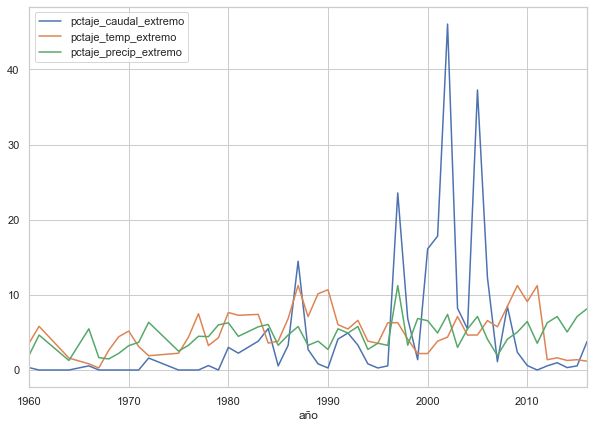

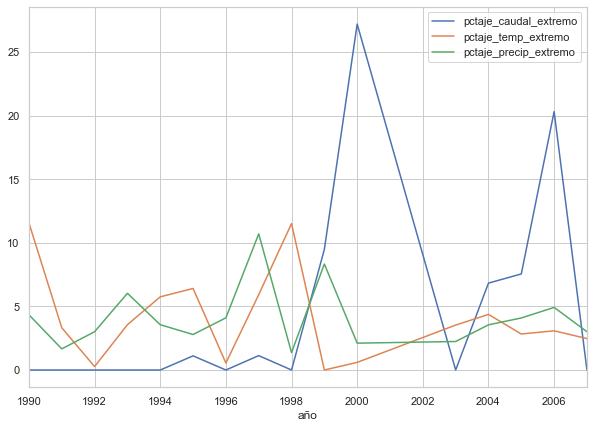

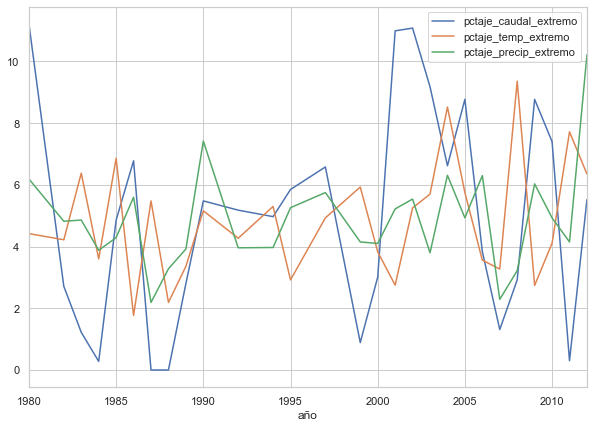

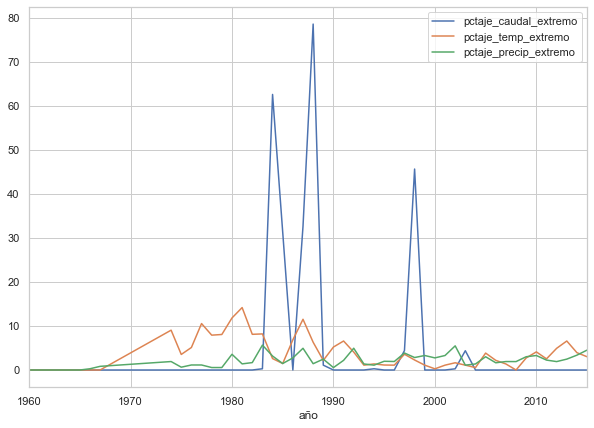

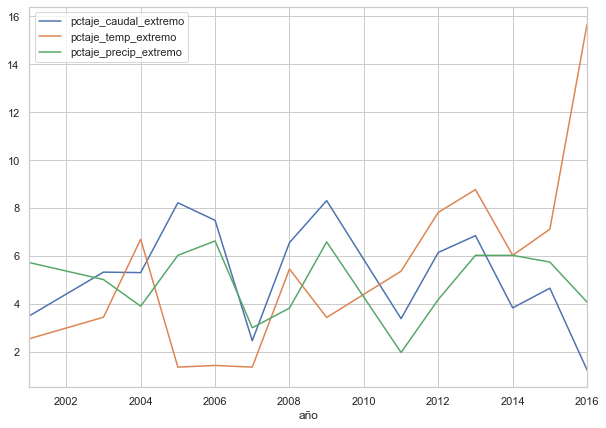

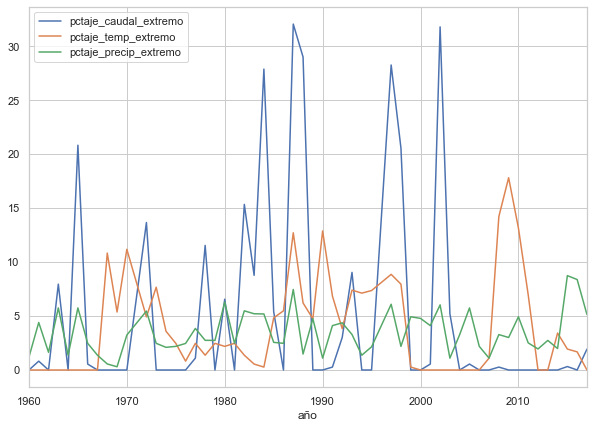

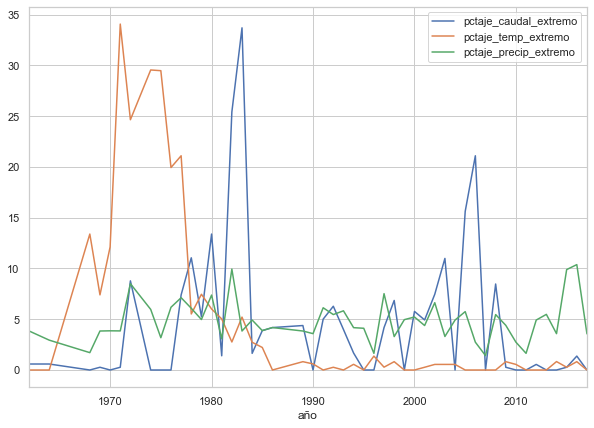

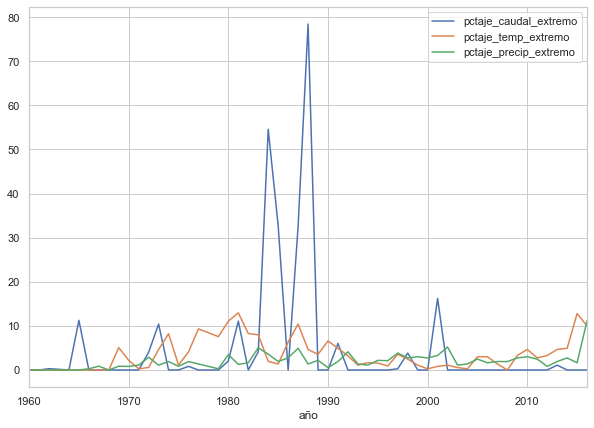

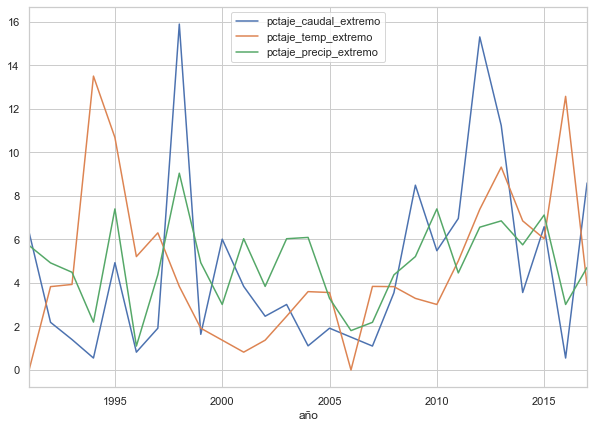

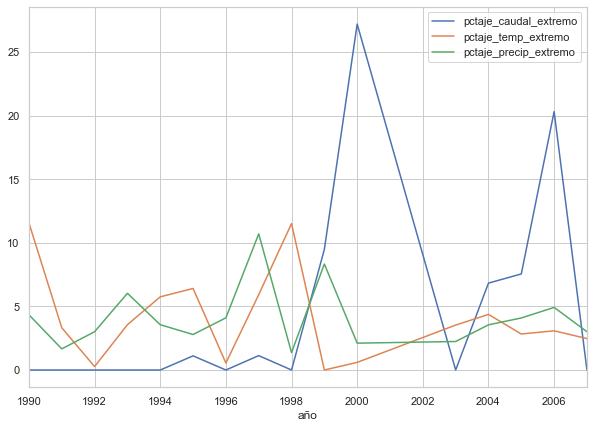

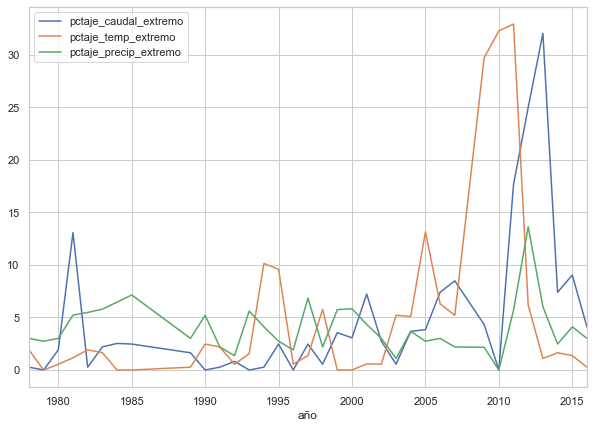

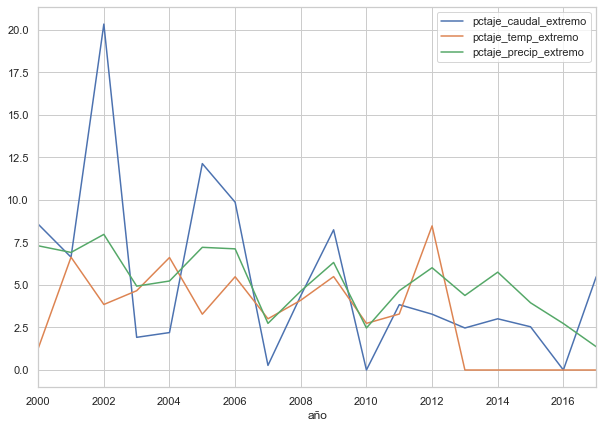

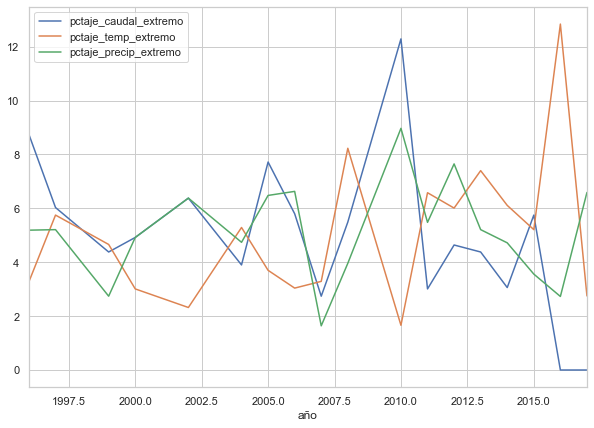

In [59]:
for codigo in codigos_aleatorios:
    time_plot_pctaje_valores_extremos_estacion(codigo)

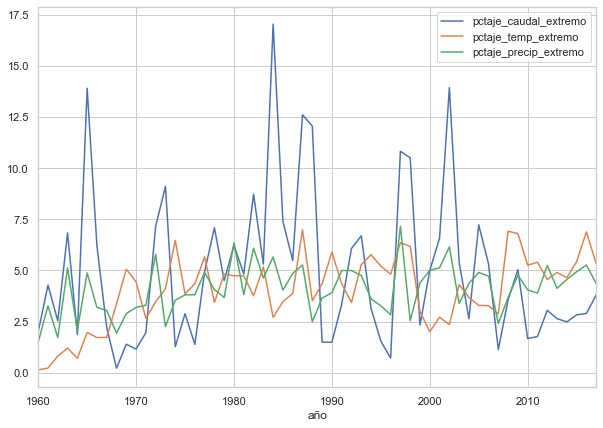

In [60]:
df_pctaje_valores_extremos.groupby(by='año')['pctaje_caudal_extremo'].mean().plot()
df_pctaje_valores_extremos.groupby(by='año')['pctaje_temp_extremo'].mean().plot()
df_pctaje_valores_extremos.groupby(by='año')['pctaje_precip_extremo'].mean().plot()
plt.legend()

En ningún de los gráficos mostrados en esta sección se puede apreciar una clara tendencia a que el porcentaje de eventos extremos haya aumentado en el tiempo.

## 7. Predicción de caudal extremo.